# K0 Alignment

In this notebook I'll allign the K0 values across .

In [1]:
import numpy  as np
import pandas as  pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../")
from regressor.model_rnn import BIRNN
from regressor.train import CustomSchedule
import os
import scipy
from scripts.utils import encoded_sequence, int_dataset
import seaborn as sns
import fastkde

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Set memory growth for all available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2025-06-17 09:02:14.283081: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-06-17 09:02:14.318655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-17 09:02:14.318797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:4c:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.53GiB deviceMemoryBandwidth: 715.34GiB/s
2025-06-17 09:02:14.320598: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-06-17 09:02:14.325558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-17 09:02:14.328743: I tensorflow/stream_executor/platform/de

In [3]:
#autoreloaa extensions
%load_ext autoreload
%autoreload 2

In [4]:
root_path = "../data/"
evidence = pd.read_csv(os.path.join(root_path, "reprocessed-03122024.csv"))

/fs/home/rlopez/ccs_paper/CCS/.env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (18,19,76) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
print(f"Shape of evidence before filtering: {evidence.shape}")
#filter out charge 1, decoys and negative intensities
evidence_filtered = evidence[(evidence["Charge"] > 1) & (evidence["Reverse"] != '+') & (evidence["Intensity"] > 0)]
print(f"Shape of evidence without decoys/charge 1/0 intensity (data was filtered already): {evidence_filtered.shape}")

Shape of evidence before filtering: (2951897, 85)
Shape of evidence without decoys/charge 1/0 intensity (data was filtered already): (2951897, 85)


# Exploration

## Overlap between MQ runs
Let's see how many peptides there're in common between runs

In [6]:
def get_common_peptides_experiments(df, experiment_1, experiment_2):
    common_peptides_df = pd.DataFrame(columns=["Modified sequence", "Charge", "m/z", "Calibrated 1/K0_1", "Calibrated 1/K0_2", "Raw file 1", "Raw file 2"])

    df_experiment_1 = df[df["Experiment"] == experiment_1]
    df_experiment_2 = df[df["Experiment"] == experiment_2]

    common_peptides = pd.merge(df_experiment_1, df_experiment_2, on=["Modified sequence", "Charge"])
    common_peptides = common_peptides[["Modified sequence", "Charge", "m/z_x", "Calibrated 1/K0_x", "Calibrated 1/K0_y", "Raw file_x", "Raw file_y"]]
    common_peptides.columns = ["Modified sequence", "Charge", "m/z", "Calibrated 1/K0_1", "Calibrated 1/K0_2", "Raw file 1", "Raw file 2"]
    common_peptides_df = pd.concat([common_peptides_df, common_peptides])
    return common_peptides_df

In [7]:
# create a listd of dataframes with common peptides per experiment
common_peptides_experiments = []
experiments = evidence_filtered["Experiment"].unique()

for experiment_1 in experiments:
    for experiment_2 in experiments:
        if experiment_1 != experiment_2:
            print(f"Comparing {experiment_1} with {experiment_2}")
            df = get_common_peptides_experiments(evidence_filtered, experiment_1, experiment_2)
            df["Experiment 1"] = experiment_1
            df["Experiment 2"] = experiment_2
            common_peptides_experiments.append(df)

# create a dataframe with all the common peptides
common_peptides_experiments_df = pd.concat(common_peptides_experiments)

Comparing Pasef_tryp_fdr001 with Drosophila_LysN_fdr001


Comparing Pasef_tryp_fdr001 with Yeast_lysn_fdr001
Comparing Pasef_tryp_fdr001 with Yeast_lysc_fdr001
Comparing Pasef_tryp_fdr001 with Ecoli_lysn_fdr001
Comparing Pasef_tryp_fdr001 with Ecoli_tryp_fdr001
Comparing Pasef_tryp_fdr001 with Drosophila_LysC_fdr001
Comparing Pasef_tryp_fdr001 with HeLa_LysN_fdr001
Comparing Pasef_tryp_fdr001 with Yeast_tryp_fdr001
Comparing Pasef_tryp_fdr001 with Celegnas_trp_fdr001
Comparing Pasef_tryp_fdr001 with HeLa_trp_fdr001
Comparing Pasef_tryp_fdr001 with Ecoli_lysc_fdr001
Comparing Pasef_tryp_fdr001 with hela_lysc_fdr001
Comparing Pasef_tryp_fdr001 with Drosophila_trp_fdr001
Comparing Pasef_tryp_fdr001 with SRMATLAS
Comparing Pasef_tryp_fdr001 with MissingGene
Comparing Pasef_tryp_fdr001 with Proteotypic
Comparing Drosophila_LysN_fdr001 with Pasef_tryp_fdr001
Comparing Drosophila_LysN_fdr001 with Yeast_lysn_fdr001
Comparing Drosophila_LysN_fdr001 with Yeast_lysc_fdr001
Comparing Drosophila_LysN_fdr001 with Ecoli_lysn_fdr001
Comparing Drosophila_LysN

In [8]:
#create a pivot table with the experiments and the number of common peptides
common_peptides_pivot = common_peptides_experiments_df.pivot_table(index=["Experiment 1"], columns=["Experiment 2"], values=["Modified sequence"], aggfunc="count")
common_peptides_pivot = common_peptides_pivot.fillna(0)
common_peptides_pivot.columns = common_peptides_pivot.columns.get_level_values(1).unique()
common_peptides_pivot

Experiment 2,Celegnas_trp_fdr001,Drosophila_LysC_fdr001,Drosophila_LysN_fdr001,Drosophila_trp_fdr001,Ecoli_lysc_fdr001,Ecoli_lysn_fdr001,Ecoli_tryp_fdr001,HeLa_LysN_fdr001,HeLa_trp_fdr001,MissingGene,Pasef_tryp_fdr001,Proteotypic,SRMATLAS,Yeast_lysc_fdr001,Yeast_lysn_fdr001,Yeast_tryp_fdr001,hela_lysc_fdr001
Experiment 1,,,,,,,,,,,,,,,,,
Celegnas_trp_fdr001,0.0,112907.0,11.0,159677.0,0.0,0.0,0.0,0.0,88424.0,51.0,230954.0,1531.0,698.0,2715.0,0.0,15021.0,26498.0
Drosophila_LysC_fdr001,112907.0,0.0,2055.0,3727667.0,80.0,0.0,60.0,0.0,71195.0,0.0,146915.0,662.0,391.0,27512.0,0.0,3086.0,78147.0
Drosophila_LysN_fdr001,11.0,2055.0,0.0,952.0,0.0,27.0,0.0,83528.0,4.0,0.0,9.0,0.0,0.0,0.0,5294.0,0.0,6.0
Drosophila_trp_fdr001,159677.0,3727667.0,952.0,0.0,56.0,0.0,51.0,0.0,153266.0,53.0,604545.0,3495.0,3445.0,2100.0,0.0,49973.0,37384.0
Ecoli_lysc_fdr001,0.0,80.0,0.0,56.0,0.0,1741.0,928035.0,0.0,2673.0,0.0,7213.0,3.0,0.0,54.0,0.0,0.0,8907.0
Ecoli_lysn_fdr001,0.0,0.0,27.0,0.0,1741.0,0.0,129.0,1749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ecoli_tryp_fdr001,0.0,60.0,0.0,51.0,928035.0,129.0,0.0,0.0,2497.0,0.0,6916.0,2.0,0.0,0.0,0.0,0.0,6033.0
HeLa_LysN_fdr001,0.0,0.0,83528.0,0.0,0.0,1749.0,0.0,0.0,3392.0,8.0,6880.0,373.0,54.0,0.0,7476.0,0.0,916.0
HeLa_trp_fdr001,88424.0,71195.0,4.0,153266.0,2673.0,0.0,2497.0,3392.0,0.0,133.0,4682372.0,176041.0,87530.0,6455.0,0.0,26050.0,546906.0


Text(0.5, 1.0, 'Number of common peptides')

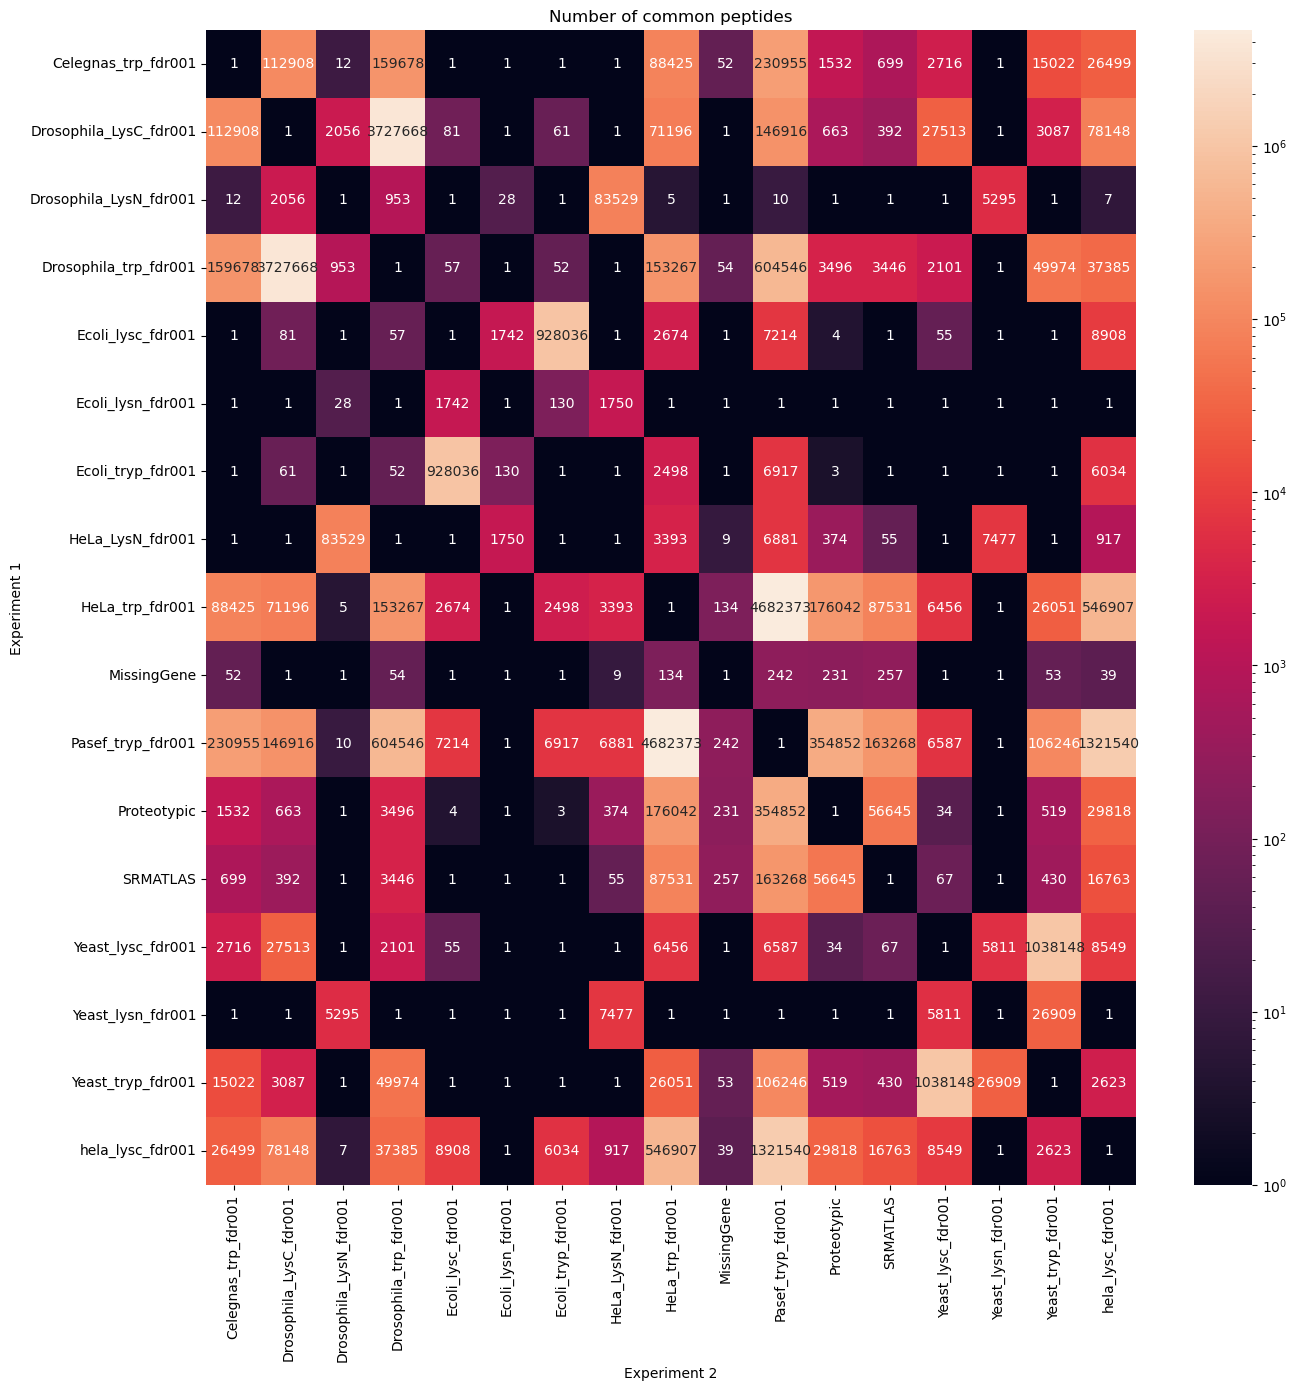

In [9]:
#plot the pivot table
fig, ax = plt.subplots(figsize=(15,15))
#lognorm is used to make the plot more readable
sns.heatmap(common_peptides_pivot + 1, annot=True, fmt=".0f", ax=ax, norm=LogNorm())
ax.set_xlabel("Experiment 2")
ax.set_ylabel("Experiment 1")
ax.set_title("Number of common peptides")

# Alignment

# Train and Predict approach

Here I'll train my model in HeLa_trp_2 and predict for the raw files to corrects the errors.

## Process the data

In [6]:
evidence_filtered["Experiment"].unique()

array(['Pasef_tryp_fdr001', 'Drosophila_LysN_fdr001', 'Yeast_lysn_fdr001',
       'Yeast_lysc_fdr001', 'Ecoli_lysn_fdr001', 'Ecoli_tryp_fdr001',
       'Drosophila_LysC_fdr001', 'HeLa_LysN_fdr001', 'Yeast_tryp_fdr001',
       'Celegnas_trp_fdr001', 'HeLa_trp_fdr001', 'Ecoli_lysc_fdr001',
       'hela_lysc_fdr001', 'Drosophila_trp_fdr001', 'SRMATLAS',
       'MissingGene', 'Proteotypic'], dtype=object)

In [7]:
hela_trp = evidence_filtered[evidence_filtered["Experiment"] == "Pasef_tryp_fdr001"]

In [8]:
pdf, axes = fastkde.fastKDE.pdf(hela_trp["m/z"].values, hela_trp["Calibrated 1/K0"].values, use_xarray=False)

In [9]:
# group by modified sequence, charge and raw file and get the counts
counts = hela_trp.groupby(["Modified sequence", "Charge", "Raw file"]).size().reset_index(name="counts")
#group the same way and get the std of calibrated K0
std = hela_trp.groupby(["Modified sequence", "Charge", "Raw file"])["Calibrated 1/K0"].std().reset_index(name="std")
#filter out the NAN values
std = std.fillna(0)
#add std as a column to hela_trp
hela_trp = pd.merge(hela_trp, std, on=["Modified sequence", "Charge", "Raw file"])
#add counts as a column to hela_trp
hela_trp = pd.merge(hela_trp, counts, on=["Modified sequence", "Charge", "Raw file"])

In [10]:
hela_trp.shape

(635259, 87)

(0.6, 1.6)

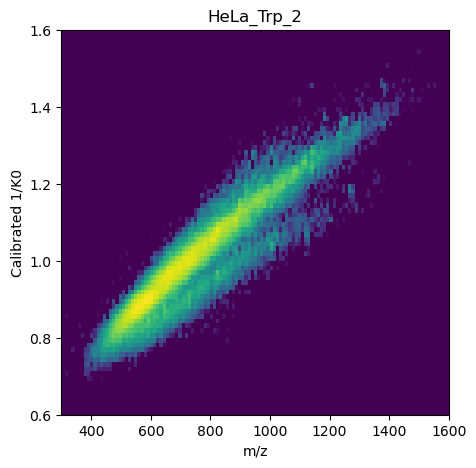

In [11]:
#plot the pdf
fig, ax = plt.subplots(figsize=(5,5))
norm = LogNorm(vmin=1e-4, vmax=pdf.max())
ax.pcolormesh(axes[0], axes[1], pdf+1e-20, cmap='viridis', norm=norm)
ax.set_xlabel("m/z")
ax.set_ylabel("Calibrated 1/K0")
ax.set_title("HeLa_Trp_2")
ax.set_xlim(300, 1600)
ax.set_ylim(0.6, 1.6)

In [12]:
#let's take the most intense peptide for a given charge per raw file
hela_trp_max = hela_trp.loc[hela_trp.groupby(["Modified sequence", "Charge"])["Intensity"].idxmax()]

In [13]:
print(f"before filtering: {len(hela_trp)}, after filtering: {len(hela_trp_max)}")

before filtering: 635259, after filtering: 132680


In [14]:
pdf, axes = fastkde.fastKDE.pdf(hela_trp_max["m/z"].values, hela_trp_max["Calibrated 1/K0"].values, use_xarray=False)

(0.6, 1.6)

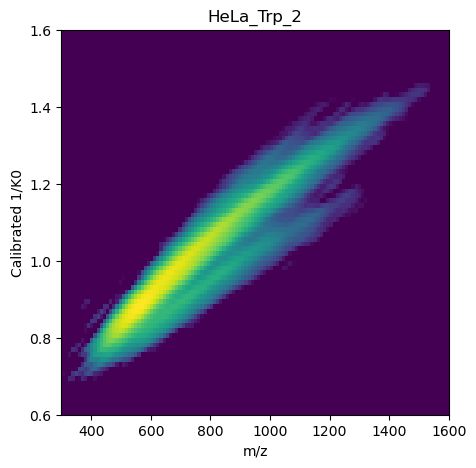

In [15]:
#plot the pdf
fig, ax = plt.subplots(figsize=(5,5))
norm = LogNorm(vmin=1e-4, vmax=pdf.max())
ax.pcolormesh(axes[0], axes[1], pdf+1e-20, cmap='viridis', norm=norm)
ax.set_xlabel("m/z")
ax.set_ylabel("Calibrated 1/K0")
ax.set_title("HeLa_Trp_2")
ax.set_xlim(300, 1600)
ax.set_ylim(0.6, 1.6)

There are still two populations, I'll take this dataset for allignment.

## Train

In [15]:
np.__version__, tf.__version__

('1.19.5', '2.2.0')

In [16]:
model_params = {
    "num_hidden" : 128,
    "num_layers" : 2,
    "num_classes" : 1,
    "embed_dim" : 66,
    "dict_size" : 32,
    "dropout_rate" : 0.4,  
}

model = BIRNN(**model_params)

model.build(input_shape=[(None, 66), (None, 1)])

model.summary()

2025-06-13 11:31:35.697716: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2025-06-13 11:31:35.785416: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3193930000 Hz
2025-06-13 11:31:35.789076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564de1f5cae0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-06-13 11:31:35.789091: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "birnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4096      
_________________________________________________________________
bidirectional (Bidirectional multiple                  263168    
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  394240    
_________________________________________________________________
global_average_pooling1d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  33024     
_________________________________________________________________
p_re_lu (PReLU)              multiple                  1         
_________________________________________________________________
dropout (Dropout)            multiple                  0     

In [22]:
hela_trp_max["Modified sequence"] = hela_trp_max["Modified sequence"].str.replace(
                                    "(Acetyl (Protein N-term))", "(ac)", regex=False).str.replace(
                                    "(Oxidation (M))", "(ox)M", regex=False)


In [23]:
hela_trp_max["Modified sequence"][hela_trp_max["Modified sequence"].str.contains("(ox)")]

/fs/home/rlopez/ccs_paper/CCS/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


220                 _(ac)AAAAAAGAGPEM(ox)VR_
243                   _(ac)AAAAAEEGM(ox)EPR_
267                  _(ac)AAAAAM(ox)AEQESAR_
342       _(ac)AAAAECDVVM(ox)AATEPELLDDQEAK_
344       _(ac)AAAAECDVVM(ox)AATEPELLDDQEAK_
                         ...                
634911                  _YYTSASGDEM(ox)VSLK_
635056                       _YYTYLIM(ox)NK_
635066              _YYVPSYEEVM(ox)NTNYSEAR_
635254                     _YYYAVYDM(ox)VVR_
635255                      _YYYDGDM(ox)ICK_
Name: Modified sequence, Length: 29550, dtype: object

In [24]:
hela_trp_max["encseq"] = encoded_sequence(hela_trp_max)
timesteps = 66
features = int_dataset(hela_trp_max, timesteps, middle=False).squeeze()
labels = hela_trp_max["Calibrated 1/K0"].values

In [25]:
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.1, random_state=42)

In [26]:
#Function to create a generator for the training data
def train_generator():
    for i in range(len(X_train)):
        yield (X_train[i,:-1], X_train[i,-1]), y_train[i]

#Function to create a generator for the validation data
def eval_generator():
    for i in range(len(X_val)):
        yield (X_val[i,:-1], X_val[i,-1]), y_val[i]

In [27]:
# Define the types and shapes for your dataset
# Assuming encseq is a variable-length list, charge is a scalar integer, and labels are strings
types = ((tf.int32, tf.int32), tf.float32)
shapes = (([66], ()), ())

# Create the TensorFlow dataset
dataset_train = tf.data.Dataset.from_generator(train_generator, output_types=types, output_shapes=shapes)

# Create the TensorFlow dataset
dataset_eval = tf.data.Dataset.from_generator(eval_generator, output_types=types, output_shapes=shapes)

In [28]:
training_parameters = {
"batch_size": 64,
"batch_size_eval": 128,
"num_epochs": 100,
"num_warmup_steps": 20000,#3 epochs
}


In [29]:
dataset_train = dataset_train.shuffle(1000).repeat(None).batch(training_parameters["batch_size"])
dataset_eval = dataset_eval.batch(training_parameters["batch_size_eval"])

In [30]:
scheduler_rnn = CustomSchedule(model_params["embed_dim"]*8, training_parameters["num_warmup_steps"])
optimizer_rnn = tf.keras.optimizers.Adam(scheduler_rnn, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
print("Maximum learnning rate:", 1/np.sqrt(model_params["embed_dim"]*8*training_parameters["num_warmup_steps"]))

Maximum learnning rate: 0.00030772872744833183


In [31]:
training_batches = len(X_train) // training_parameters["batch_size"]
eval_batches = len(X_val) // training_parameters["batch_size_eval"]

In [32]:
class LearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print(f"Current learning rate: {lr:.5f}")

In [33]:
path = "../models/aligner"
cb = [tf.keras.callbacks.CSVLogger(f'{path}/training.log', append=False),  
    tf.keras.callbacks.ModelCheckpoint(f'{path}/checkpoints/best', save_best_only=True, save_weights_only=True),
    LearningRateCallback()]

In [34]:
model.compile(loss='mean_squared_error', optimizer=optimizer_rnn)

In [35]:
history = model.fit(
dataset_train, epochs=training_parameters["num_epochs"], validation_data=dataset_eval,
steps_per_epoch=training_batches, validation_steps=eval_batches, callbacks=cb)

Current learning rate: 0.00000
Epoch 1/100


2024-12-03 11:26:44.396588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-12-03 11:26:45.202800: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1865/1865 [==============================] - 103s 55ms/step - loss: 0.3285 - val_loss: 0.0062
Current learning rate: 0.00003
Epoch 2/100
1865/1865 [==============================] - 99s 53ms/step - loss: 0.0143 - val_loss: 0.0017
Current learning rate: 0.00006
Epoch 3/100
1865/1865 [==============================] - 99s 53ms/step - loss: 0.0086 - val_loss: 0.0013
Current learning rate: 0.00009
Epoch 4/100
1865/1865 [==============================] - 120s 64ms/step - loss: 0.0068 - val_loss: 0.0013
Current learning rate: 0.00011
Epoch 5/100
1865/1865 [==============================] - 89s 48ms/step - loss: 0.0054 - val_loss: 9.2218e-04
Current learning rate: 0.00014
Epoch 6/100
1865/1865 [==============================] - 98s 53ms/step - loss: 0.0043 - val_loss: 0.0010
Current learning rate: 0.00017
Epoch 7/100
1865/1865 [==============================] - 97s 52ms/step - loss: 0.0035 - val_loss: 0.0011
Current learning rate: 0.00020
Epoch 8/100
1865/1865 [==============================]

In [35]:
loss = pd.read_csv(f'{path}/training.log', sep=',')

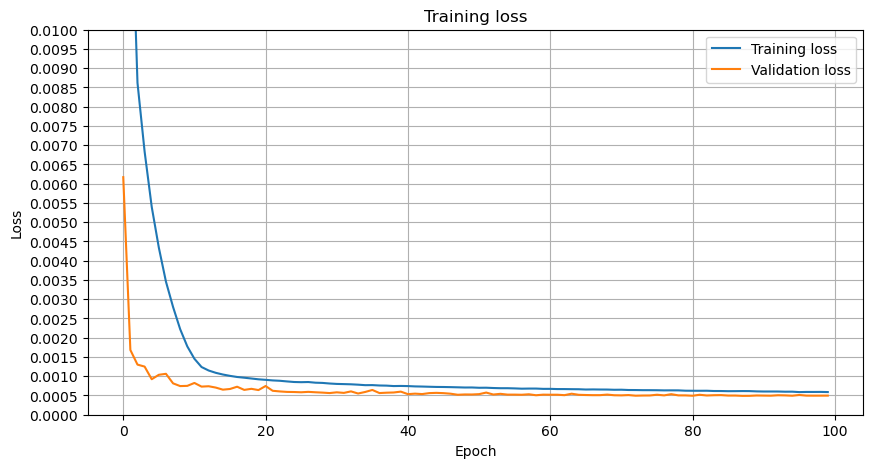

In [36]:
#plot the training loss
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1)

ax.plot(loss["loss"], label = "Training loss")
ax.plot(loss["val_loss"], label = "Validation loss")
ax.set_title("Training loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim(0, 0.01)
ax.legend()
#add ticks every 0.005
ax.yaxis.set_major_locator(plt.MultipleLocator(0.0005))
#add grid
ax.grid(True)

## Run predictions

Load in model

In [16]:
model_params = {
    "num_hidden" : 128,
    "num_layers" : 2,
    "num_classes" : 1,
    "embed_dim" : 66,
    "dict_size" : 32,
    "dropout_rate" : 0.4,  
}

In [17]:
#load in the best model
path = "../models/aligner"
model = BIRNN(**model_params)
model.build(input_shape=[(None, 66), (None, 1)])
model.load_weights(f'{path}/checkpoints/best')

2025-06-17 09:02:57.887104: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2025-06-17 09:02:57.914959: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2695070000 Hz
2025-06-17 09:02:57.919277: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562aa9995aa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-06-17 09:02:57.919292: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-06-17 09:02:57.980161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-17 09:02:57.980332: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562a9793f170 initialized for platform CUDA (this does not 

In [18]:
#replace modification names
evidence_filtered["Modified sequence"] = evidence_filtered["Modified sequence"].str.replace("(Acetyl (Protein N-term))", "(ac)", regex=False).str.replace("(Oxidation (M))", "(ox)M", regex=False)

In [19]:
evidence_filtered["Experiment"].unique()

array(['Pasef_tryp_fdr001', 'Drosophila_LysN_fdr001', 'Yeast_lysn_fdr001',
       'Yeast_lysc_fdr001', 'Ecoli_lysn_fdr001', 'Ecoli_tryp_fdr001',
       'Drosophila_LysC_fdr001', 'HeLa_LysN_fdr001', 'Yeast_tryp_fdr001',
       'Celegnas_trp_fdr001', 'HeLa_trp_fdr001', 'Ecoli_lysc_fdr001',
       'hela_lysc_fdr001', 'Drosophila_trp_fdr001', 'SRMATLAS',
       'MissingGene', 'Proteotypic'], dtype=object)

In [20]:
experiments = evidence_filtered["Experiment"].unique()
df_list = []

for experiment in experiments:
    print("-" * 50)
    print(f"Processing {experiment}")
    df = evidence_filtered[evidence_filtered["Experiment"] == experiment]
    df_max = df.loc[df.groupby(["Modified sequence", "Charge", "Raw file"])["Intensity"].idxmax()]
    df_max["encseq"] = encoded_sequence(df_max)
    timesteps = 66
    features = int_dataset(df_max, timesteps, middle=False).squeeze()
    labels = df_max["Calibrated 1/K0"].values
    
    def predict_generator():
        for i in range(len(features)):
            yield (features[i,:-1], features[i,-1]), labels[i]

    types = ((tf.int32, tf.int32), tf.float32)
    shapes = (([66], ()), ())
    dataset_exp = tf.data.Dataset.from_generator(predict_generator, output_types=types, output_shapes=shapes)
    dataset_exp = dataset_exp.batch(128)

    print(f"Predicting K0 for {experiment}")

    predicted_K0 = model.predict(dataset_exp)
    
    print(f"Aligning K0 for {experiment}")

    df_max["Predicted 1/K0"] = predicted_K0.squeeze()
    #group by raw file and calculate the median of the difference between the predicted K0 and the calibrated K0
    df_max["delta"] = df_max["Calibrated 1/K0"] - df_max["Predicted 1/K0"]    
    median_delta = df_max.groupby("Raw file")["delta"].median().reset_index(name="median_delta")
    #add the median delta to the dataframe
    df = pd.merge(df, median_delta, on="Raw file")
    #calculate the alligned K0
    df["Aligned 1/K0"] = df["Calibrated 1/K0"] - df["median_delta"]
    df_list.append(df)

evidence_aligned = pd.concat(df_list)


--------------------------------------------------
Processing Pasef_tryp_fdr001
Predicting K0 for Pasef_tryp_fdr001


2025-06-17 09:04:31.776729: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-17 09:04:32.037813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Aligning K0 for Pasef_tryp_fdr001
--------------------------------------------------
Processing Drosophila_LysN_fdr001
Predicting K0 for Drosophila_LysN_fdr001
Aligning K0 for Drosophila_LysN_fdr001
--------------------------------------------------
Processing Yeast_lysn_fdr001
Predicting K0 for Yeast_lysn_fdr001
Aligning K0 for Yeast_lysn_fdr001
--------------------------------------------------
Processing Yeast_lysc_fdr001
Predicting K0 for Yeast_lysc_fdr001
Aligning K0 for Yeast_lysc_fdr001
--------------------------------------------------
Processing Ecoli_lysn_fdr001
Predicting K0 for Ecoli_lysn_fdr001
Aligning K0 for Ecoli_lysn_fdr001
--------------------------------------------------
Processing Ecoli_tryp_fdr001
Predicting K0 for Ecoli_tryp_fdr001
Aligning K0 for Ecoli_tryp_fdr001
--------------------------------------------------
Processing Drosophila_LysC_fdr001
Predicting K0 for Drosophila_LysC_fdr001
Aligning K0 for Drosophila_LysC_fdr001
------------------------------------

In [21]:
evidence_aligned["Experiment"].unique()

array(['Pasef_tryp_fdr001', 'Drosophila_LysN_fdr001', 'Yeast_lysn_fdr001',
       'Yeast_lysc_fdr001', 'Ecoli_lysn_fdr001', 'Ecoli_tryp_fdr001',
       'Drosophila_LysC_fdr001', 'HeLa_LysN_fdr001', 'Yeast_tryp_fdr001',
       'Celegnas_trp_fdr001', 'HeLa_trp_fdr001', 'Ecoli_lysc_fdr001',
       'hela_lysc_fdr001', 'Drosophila_trp_fdr001', 'SRMATLAS',
       'MissingGene', 'Proteotypic'], dtype=object)

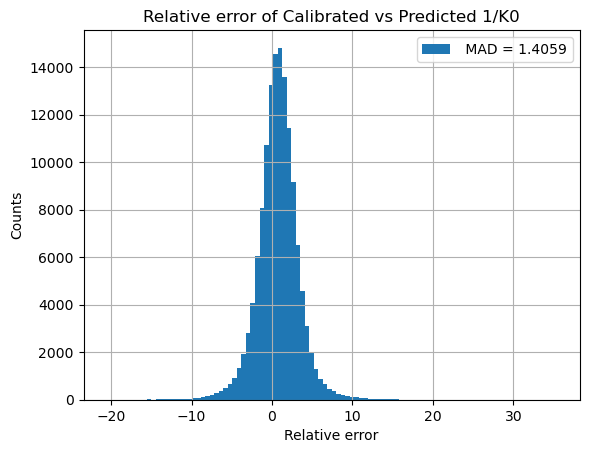

In [22]:
err_rel = (df_max["Calibrated 1/K0"].values - df_max["Predicted 1/K0"].values) / df_max["Calibrated 1/K0"] * 100
mad = scipy.stats.median_absolute_deviation(err_rel, scale=1.0)
ax = err_rel.hist(bins=100, label=f" MAD = {mad:.4f}")
ax.set_xlabel("Relative error")
ax.set_ylabel("Counts")
ax.set_title("Relative error of Calibrated vs Predicted 1/K0")
ax.legend()

In [23]:
def get_common_peptides_experiments(df, experiment_1, experiment_2):
    common_peptides_df = pd.DataFrame(columns=["Modified sequence", "Charge", "m/z", "Calibrated 1/K0_1", "Calibrated 1/K0_2", "Raw file 1", "Raw file 2",
                                               "Aligned 1/K0_1", "Aligned 1/K0_2"])

    df_experiment_1 = df[df["Experiment"] == experiment_1]
    df_experiment_2 = df[df["Experiment"] == experiment_2]

    common_peptides = pd.merge(df_experiment_1, df_experiment_2, on=["Modified sequence", "Charge"])
    common_peptides = common_peptides[["Modified sequence", "Charge", "m/z_x", "Calibrated 1/K0_x", "Calibrated 1/K0_y", "Raw file_x", "Raw file_y",
                                       "Aligned 1/K0_x", "Aligned 1/K0_y"]]
    common_peptides.columns = ["Modified sequence", "Charge", "m/z", "Calibrated 1/K0_1", "Calibrated 1/K0_2", "Raw file 1", "Raw file 2",
                               "Aligned 1/K0_1", "Aligned 1/K0_2"]
    common_peptides_df = pd.concat([common_peptides_df, common_peptides])
    return common_peptides_df

In [24]:
# create a listd of dataframes with common peptides per experiment
common_peptides_experiments = []
experiments = evidence_aligned["Experiment"].unique()
experiment_1 = "Pasef_tryp_fdr001"

for experiment_2 in experiments:
    print("Processing", experiment_2)

    df = get_common_peptides_experiments(evidence_aligned, experiment_1, experiment_2)
    df["Experiment 1"] = experiment_1
    df["Experiment 2"] = experiment_2
    common_peptides_experiments.append(df)

# create a dataframe with all the common peptides
common_peptides_experiments_df = pd.concat(common_peptides_experiments)
print(f"Number of common peptides: {len(common_peptides_experiments_df)}")

Processing Pasef_tryp_fdr001
Processing Drosophila_LysN_fdr001
Processing Yeast_lysn_fdr001
Processing Yeast_lysc_fdr001
Processing Ecoli_lysn_fdr001
Processing Ecoli_tryp_fdr001
Processing Drosophila_LysC_fdr001
Processing HeLa_LysN_fdr001
Processing Yeast_tryp_fdr001
Processing Celegnas_trp_fdr001
Processing HeLa_trp_fdr001
Processing Ecoli_lysc_fdr001
Processing hela_lysc_fdr001
Processing Drosophila_trp_fdr001
Processing SRMATLAS
Processing MissingGene
Processing Proteotypic
Number of common peptides: 31557920


In [25]:
evidence_aligned["Experiment"].unique()

array(['Pasef_tryp_fdr001', 'Drosophila_LysN_fdr001', 'Yeast_lysn_fdr001',
       'Yeast_lysc_fdr001', 'Ecoli_lysn_fdr001', 'Ecoli_tryp_fdr001',
       'Drosophila_LysC_fdr001', 'HeLa_LysN_fdr001', 'Yeast_tryp_fdr001',
       'Celegnas_trp_fdr001', 'HeLa_trp_fdr001', 'Ecoli_lysc_fdr001',
       'hela_lysc_fdr001', 'Drosophila_trp_fdr001', 'SRMATLAS',
       'MissingGene', 'Proteotypic'], dtype=object)

### Before Alignment

Drosophila_LysN_fdr001
Yeast_lysn_fdr001
Yeast_lysc_fdr001
Ecoli_lysn_fdr001
Ecoli_tryp_fdr001
Drosophila_LysC_fdr001
HeLa_LysN_fdr001
Yeast_tryp_fdr001
Celegnas_trp_fdr001
HeLa_trp_fdr001
Ecoli_lysc_fdr001
hela_lysc_fdr001
Drosophila_trp_fdr001
SRMATLAS
MissingGene
Proteotypic


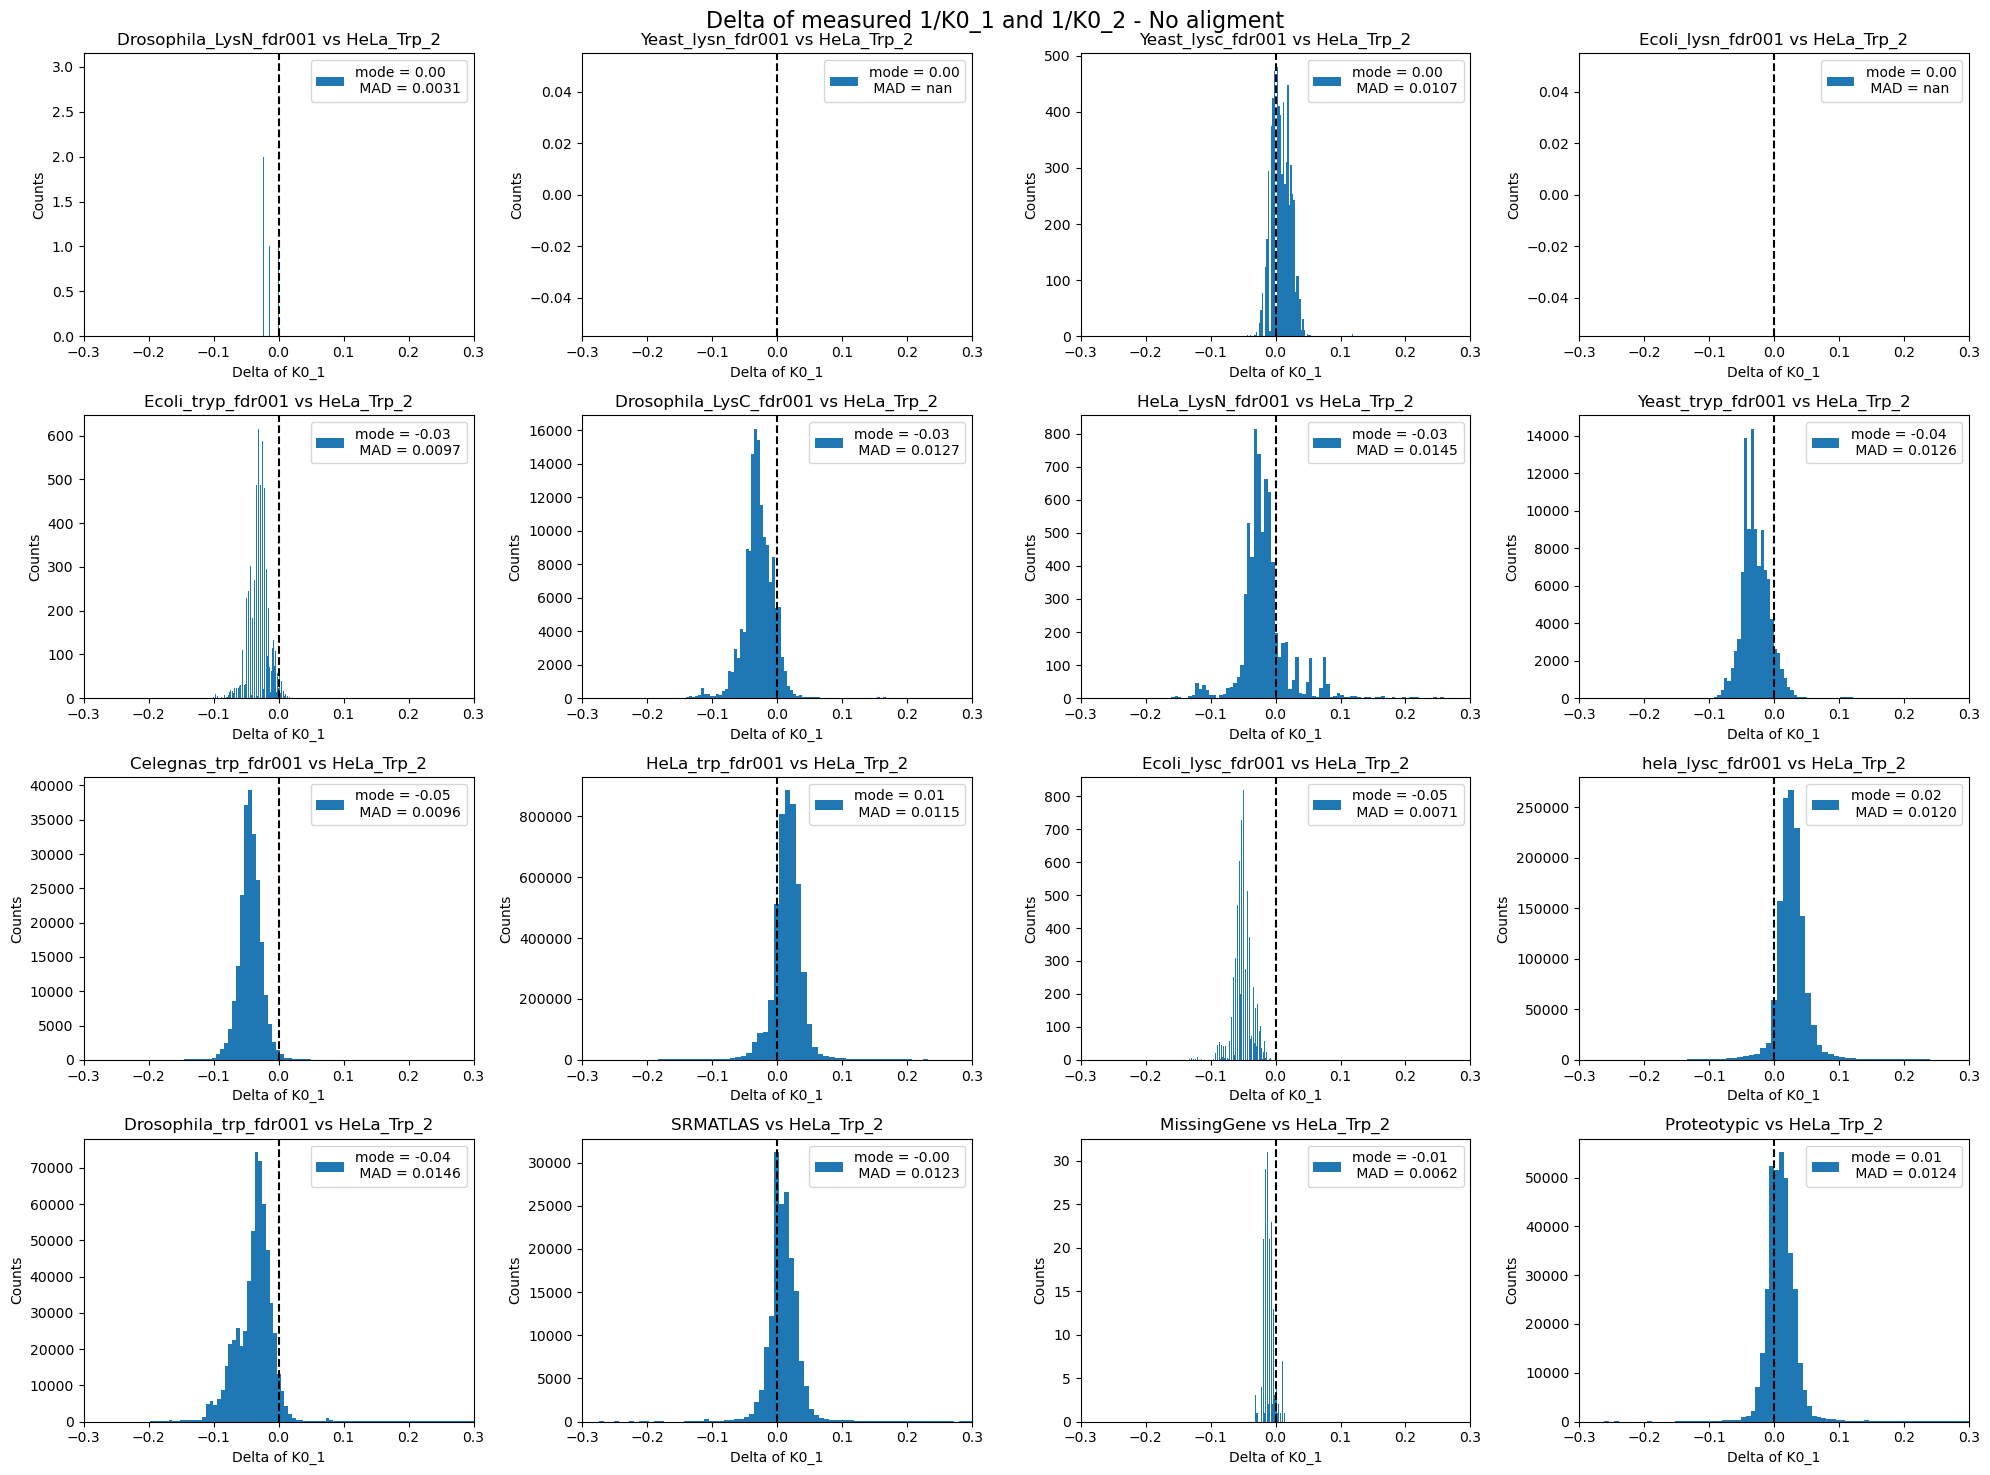

In [26]:
# for each experiment, plot the relative error of 1/K0_1 and 1/K0_2 and add the mode as label

n_cols = 4
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))
#title of the plot
fig.suptitle("Delta of measured 1/K0_1 and 1/K0_2 - No aligment", fontsize=16)

experiments = evidence_aligned["Experiment"].unique()
#remove HeLa_Trp_2 from the list of experiments because it is the reference
experiments = experiments[experiments != "Pasef_tryp_fdr001"]

for i, experiment in enumerate(experiments):
    print(experiment)
    mask = (common_peptides_experiments_df["Experiment 2"] == experiment)&(common_peptides_experiments_df["Experiment 1"] == "Pasef_tryp_fdr001")
    df = common_peptides_experiments_df[mask]

    delta = (df["Calibrated 1/K0_2"] - df["Calibrated 1/K0_1"])
    counts, x = np.histogram(delta, bins=100)
    #get the mode of the relative error 
    mode = x[np.argmax(counts)]
    #add the mode to the dataframe
    common_peptides_experiments_df.loc[mask, "mode"] = mode
    mad = scipy.stats.median_absolute_deviation(delta, scale=1.0)
    ax = axes[i//n_cols, i%n_cols]
    ax.hist(delta, bins=100, label=f"mode = {mode:.2f}\n MAD = {mad:.4f}")
    ax.set_xlabel("Delta of K0_1")
    ax.set_ylabel("Counts")
    ax.set_title(f"{experiment} vs HeLa_Trp_2")
    ax.legend()
    #set xlim so all the plots are comparable
    ax.set_xlim(-0.3, 0.3)

    #add a vertical line at 0
    ax.axvline(x=0, color="black", linestyle="--")

plt.tight_layout()

### After Alignment

Experiment: Drosophila_LysN_fdr001, mode: 0.00
Experiment: Yeast_lysn_fdr001, mode: 0.00
Experiment: Yeast_lysc_fdr001, mode: -0.00
Experiment: Ecoli_lysn_fdr001, mode: 0.00
Experiment: Ecoli_tryp_fdr001, mode: -0.00
Experiment: Drosophila_LysC_fdr001, mode: 0.00
Experiment: HeLa_LysN_fdr001, mode: 0.00
Experiment: Yeast_tryp_fdr001, mode: -0.00
Experiment: Celegnas_trp_fdr001, mode: 0.00
Experiment: HeLa_trp_fdr001, mode: -0.01
Experiment: Ecoli_lysc_fdr001, mode: -0.00
Experiment: hela_lysc_fdr001, mode: -0.01
Experiment: Drosophila_trp_fdr001, mode: -0.01
Experiment: SRMATLAS, mode: -0.00
Experiment: MissingGene, mode: 0.01
Experiment: Proteotypic, mode: -0.01


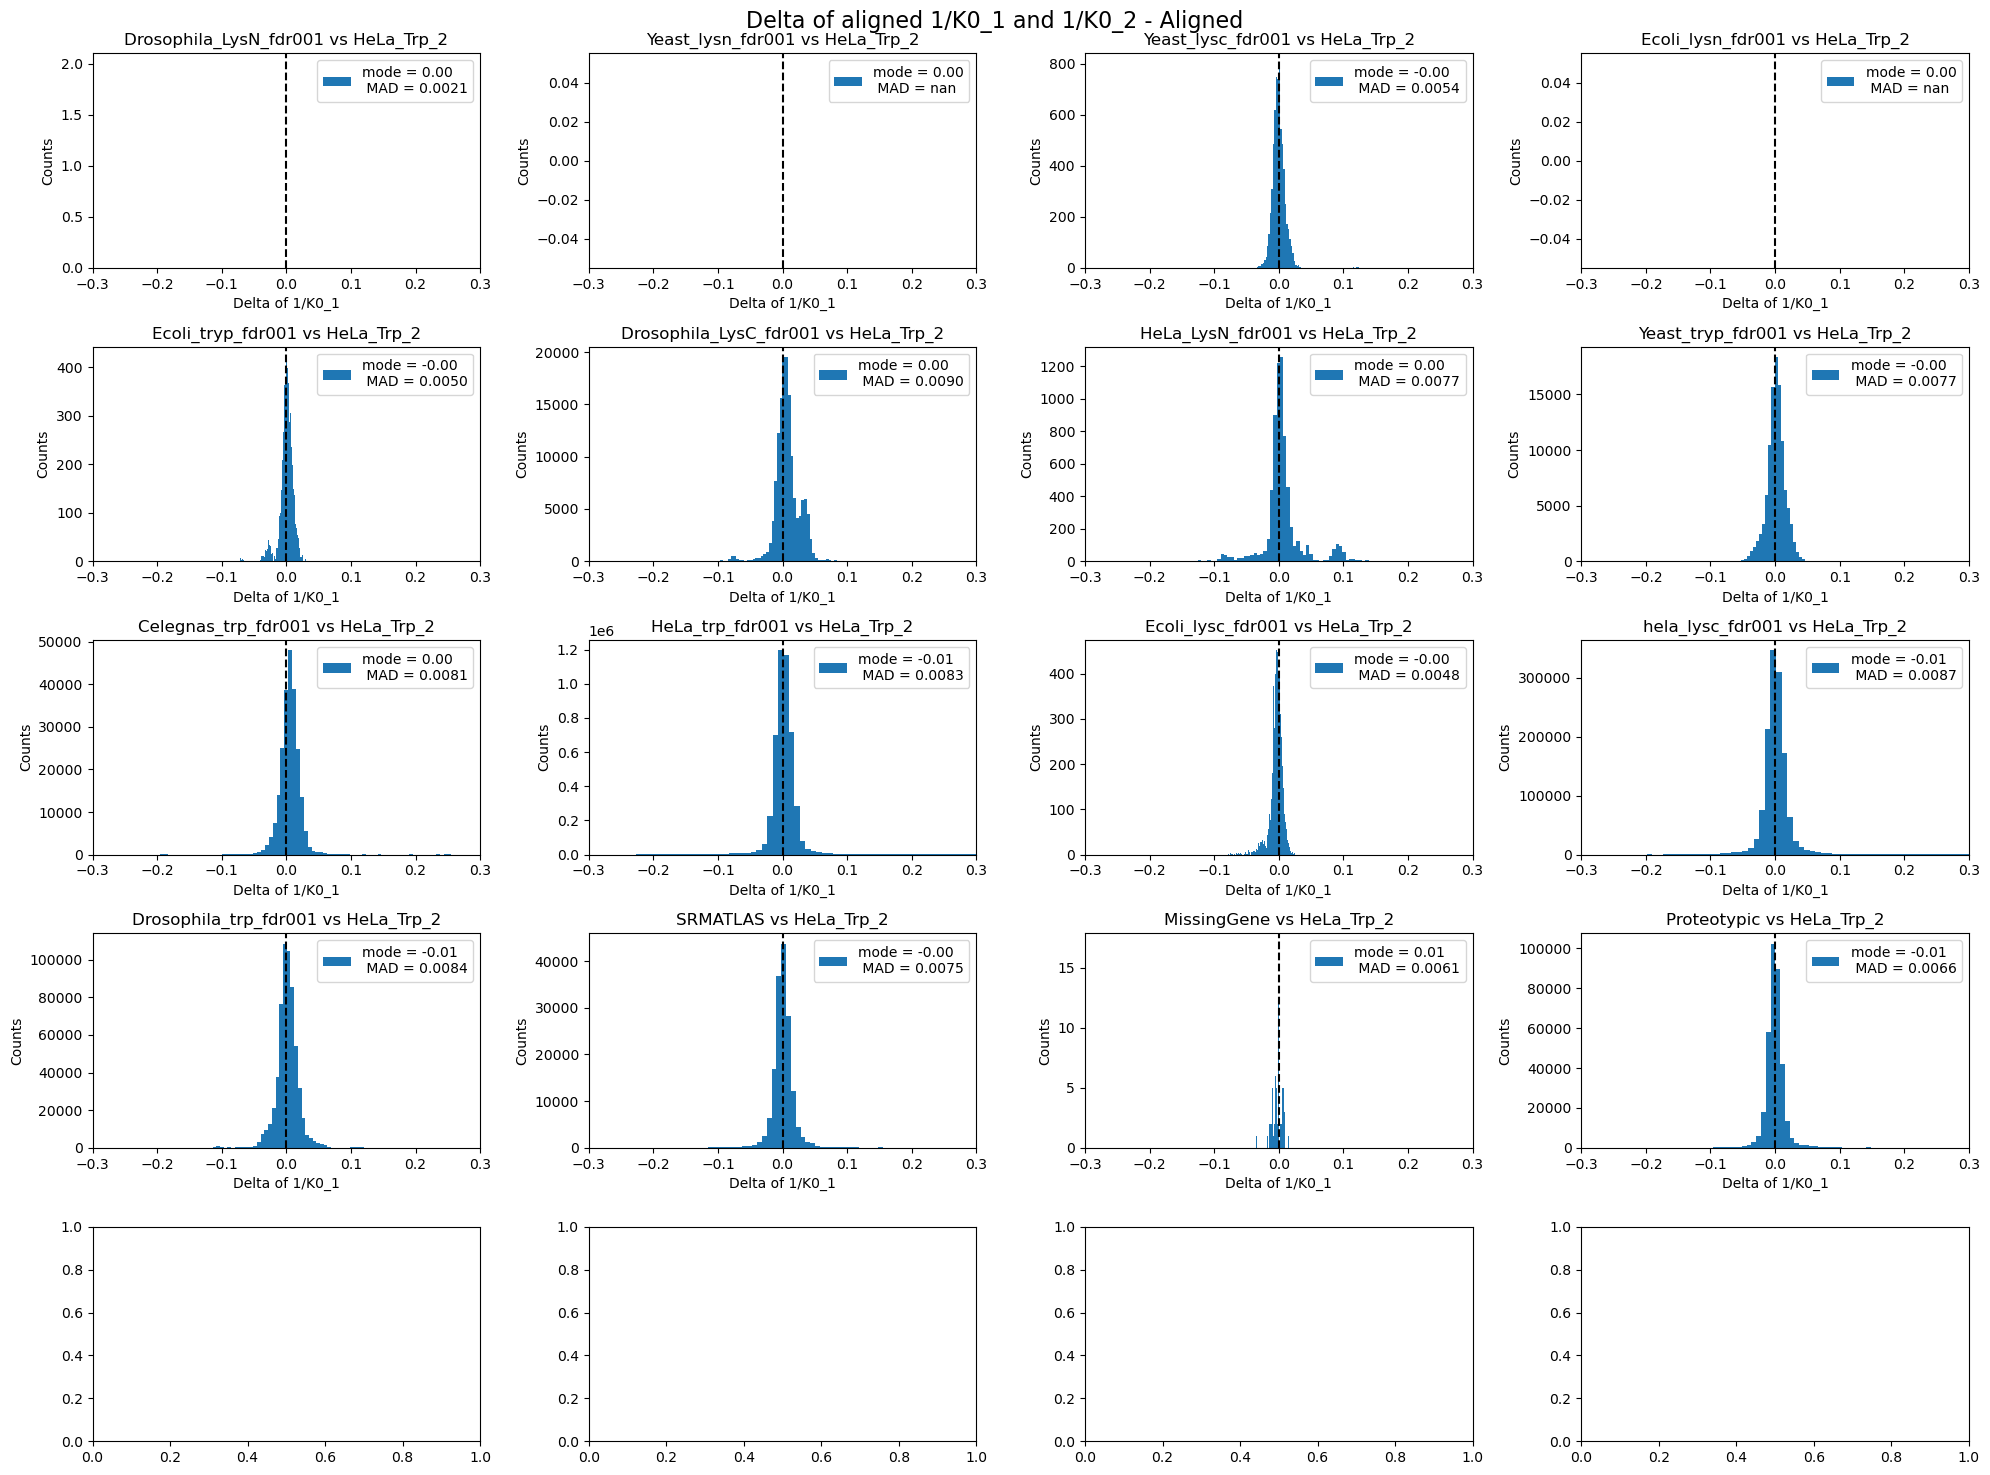

In [27]:
# for each experiment, plot the relative error of CCS_1 and CCS_2 and add the mode as label

n_cols = 4
n_rows = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))
#title of the plot
fig.suptitle("Delta of aligned 1/K0_1 and 1/K0_2 - Aligned", fontsize=16)

experiments = evidence_aligned["Experiment"].unique()
#remove HeLa_Trp_2 from the list of experiments because it is the reference
experiments = experiments[experiments != "Pasef_tryp_fdr001"]

for i, experiment in enumerate(experiments):
    #print(experiment)

    df = common_peptides_experiments_df[(common_peptides_experiments_df["Experiment 2"] == experiment)&
                                        (common_peptides_experiments_df["Experiment 1"] == "Pasef_tryp_fdr001")]

    if experiment != "Pasef_tryp_fdr001":
        delta = (df["Aligned 1/K0_2"] - df["Aligned 1/K0_1"])
    else:
        delta = (df["Aligned 1/K0_2"] - df["Calibrated 1/K0_1"])
    counts, x = np.histogram(delta, bins=100)
    #get the mode of the relative error 
    mode = x[np.argmax(counts)]
    print(f"Experiment: {experiment}, mode: {mode:.2f}")
    #add the mode to the dataframe
    common_peptides_experiments_df.loc[(common_peptides_experiments_df["Experiment 2"] == experiment)&
                                        (common_peptides_experiments_df["Experiment 1"] == "Pasef_tryp_fdr001"), "mode"] = mode
    mad = scipy.stats.median_absolute_deviation(delta, scale=1.0)
    ax = axes[i//n_cols, i%n_cols]
    ax.hist(delta, bins=100, label=f"mode = {mode:.2f}\n MAD = {mad:.4f}")
    ax.set_xlabel("Delta of 1/K0_1")
    ax.set_ylabel("Counts")
    ax.set_title(f"{experiment} vs HeLa_Trp_2")
    ax.legend()
    #set xlim so all the plots are comparable
    ax.set_xlim(-0.3, 0.3)

    #add a vertical line at 0
    ax.axvline(x=0, color="black", linestyle="--")

plt.tight_layout()

this looks good already

In [28]:
pdf, axes = fastkde.fastKDE.pdf(evidence_aligned["m/z"].values, evidence_aligned["Aligned 1/K0"].values, use_xarray=False)
pdf += 1e-20

Text(0.5, 1.0, 'Density plot')

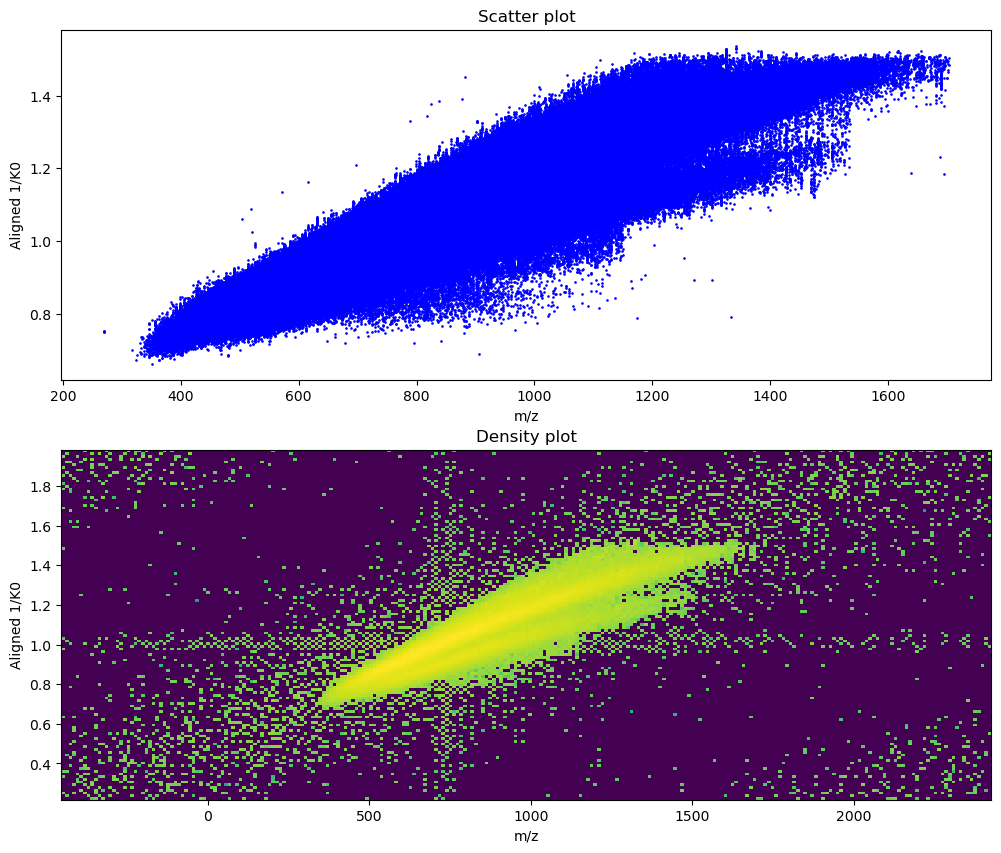

In [29]:
fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=1)
#scatter plot
evidence_aligned.plot.scatter(x="m/z", y="Aligned 1/K0", s = 0.8, c="blue", ax=ax[0])
ax[0].set_title("Scatter plot")

#plot the pdf
norm = LogNorm()
ax[1].pcolormesh(axes[0], axes[1], pdf, cmap='viridis', norm=norm,)
ax[1].set_xlabel("m/z")
ax[1].set_ylabel("Aligned 1/K0")
ax[1].set_title("Density plot")

In [45]:
#important columns
important_columns = ["Modified sequence", "Charge", "m/z", "Calibrated 1/K0", "Aligned 1/K0", "Raw file", "Experiment", 'Calibrated 1/K0 values', 'Intensity values', "Reverse", "Intensity"]
evidence_aligned_subset = evidence_aligned[important_columns]

In [46]:
test_experiments = ["SRMATLAS", "MissingGene", "Proteotypic"]

In [47]:
evidence_test = evidence_aligned_subset[evidence_aligned_subset["Experiment"].isin(test_experiments)]
evidence_train = evidence_aligned_subset[~evidence_aligned_subset["Experiment"].isin(test_experiments)]

In [48]:
evidence_test["Experiment"].unique(), evidence_train["Experiment"].unique()

(array(['SRMATLAS', 'MissingGene', 'Proteotypic'], dtype=object),
 array(['Pasef_tryp_fdr001', 'Drosophila_LysN_fdr001', 'Yeast_lysn_fdr001',
        'Yeast_lysc_fdr001', 'Ecoli_lysn_fdr001', 'Ecoli_tryp_fdr001',
        'Drosophila_LysC_fdr001', 'HeLa_LysN_fdr001', 'Yeast_tryp_fdr001',
        'Celegnas_trp_fdr001', 'HeLa_trp_fdr001', 'Ecoli_lysc_fdr001',
        'hela_lysc_fdr001', 'Drosophila_trp_fdr001'], dtype=object))

In [49]:
evidence_test.shape, evidence_train.shape

((325891, 11), (2626006, 11))

In [50]:
#save the evidence_aligned as pickle as well
evidence_train.to_csv(os.path.join(root_path, "evidence_aligned_trainv2660.csv"), sep='\t')
evidence_train.to_pickle(os.path.join(root_path, "evidence_aligned_trainv2660.pkl"))

In [51]:
#save the evidence_aligned as pickle as well
evidence_test.to_csv(os.path.join(root_path, "evidence_test_fromRawFiles_2pop_v2660.csv"), sep='\t')
evidence_test.to_pickle(os.path.join(root_path, "evidence_test_fromRawFiles_2pop_v2660.pkl"))